<a href="https://colab.research.google.com/github/dystaSatria/Deep-Learning/blob/main/Internship%20Projects/DenseNet/DenseNet-ImageClassification-v6/DenseNet201/DenseNet201.ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Instal CatBoost menggunakan pip
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


Starting enhanced DenseNet201 classification with multiple classifiers on /content/drive/MyDrive/train...
Creating data generators...
Found 8192 images belonging to 4 classes.
Found 2048 images belonging to 4 classes.
Number of classes: 4
Class names: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']

===== Training Standard DenseNet201 Model =====
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 3775s 14s/step - accuracy: 0.4248 - loss: 1.5438 - val_accuracy: 0.5732 - val_loss: 0.9945
Epoch 2/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1099s 4s/step - accuracy: 0.6432 - loss: 0.8558 - val_accuracy: 0.6196 - val_loss: 0.8385
Epoch 3/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1073s 4s/step - accuracy: 0.6841 - loss: 0.7489 - val_accuracy: 0.6187 - val_loss: 0.7952
Epoch 4/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1069s 4s/step - accuracy: 0.7284 - loss: 0.6664 - val_accuracy: 0.6172 - val_loss: 0.7927
Epoch 5/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1115s 4s/step - accuracy: 0.7205 - loss: 0.6562 - val_accuracy: 0.6597 - val_loss: 0.7658
Epoch 6/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1071s 4s/step - accuracy: 0.7500 - loss: 0.6168 - val_accuracy: 0.6260 - val_loss: 0.8172
Epoch 7/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1062s 4s/step - accuracy: 0.7452 - loss: 0.6023 - val_accuracy: 0.6445 - val_loss: 0.7554
Epoch 8/30
256/256 ━━━━━━━━━━━━━━━━━━━━ 1062s 4s/step - accuracy: 0.7543 - loss: 0.5803 -

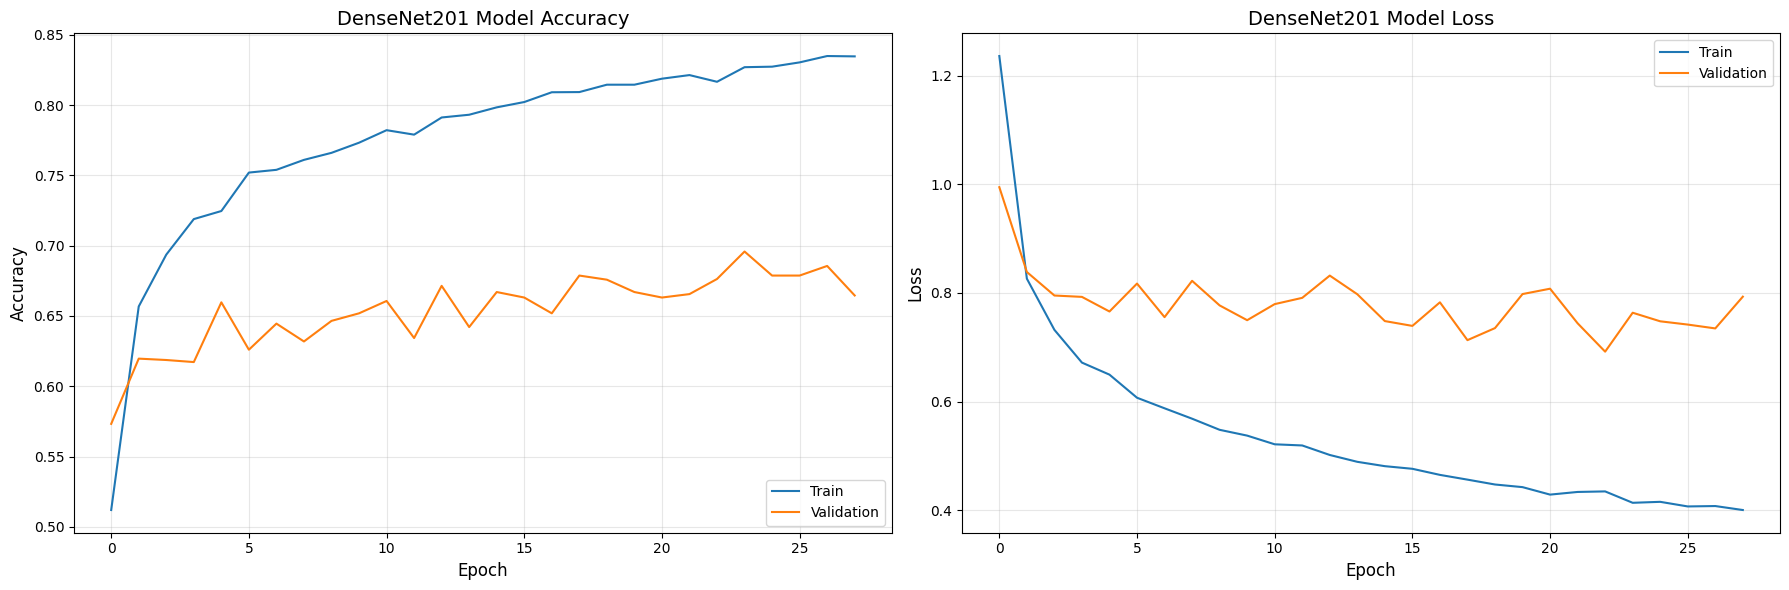

64/64 ━━━━━━━━━━━━━━━━━━━━ 228s 3s/step


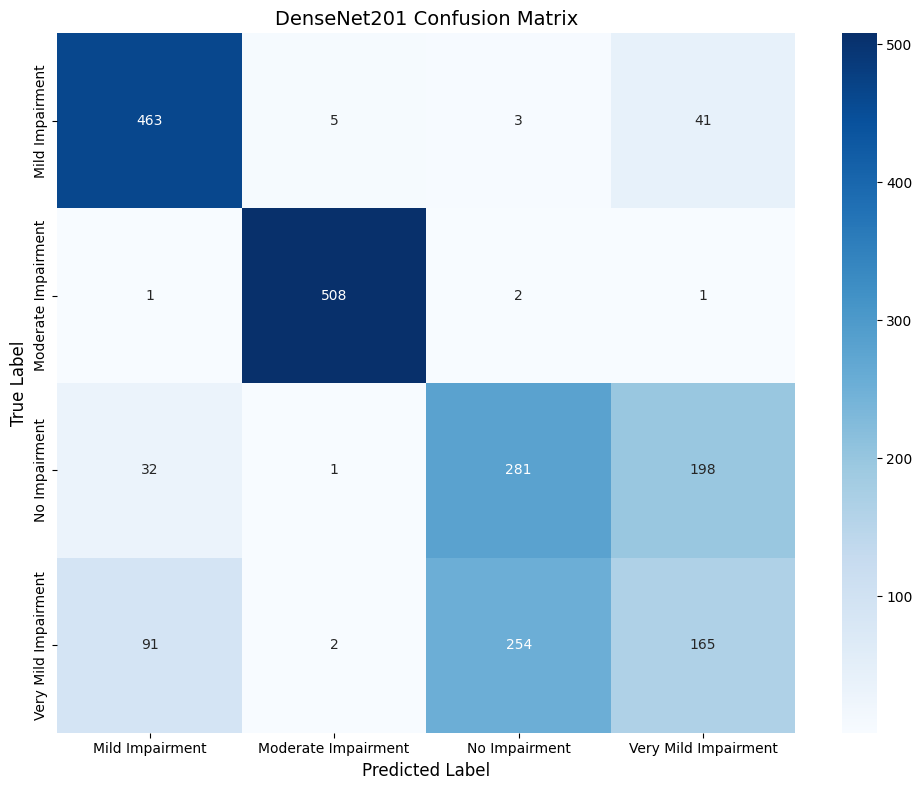


===== Extracting Features from DenseNet201 =====
Extracting training features...
Training features shape: (8192, 1920)
Extracting validation features...
Validation features shape: (2048, 1920)
Extracting test features...
Test features shape: (2048, 1920)

===== Training and Evaluating SVMs with Different Kernels =====
Training SVM with linear kernel...
Training SVM with rbf kernel...
Training SVM with poly kernel...
Training SVM with sigmoid kernel...

===== Training and Evaluating Boosting Methods =====
Training Gradient Boosting classifier...


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, matthews_corrcoef,
    cohen_kappa_score, fbeta_score, roc_curve, auc,
    precision_recall_curve, average_precision_score
)
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Try to import LightGBM
try:
    import lightgbm as lgbm
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("Warning: LightGBM is not installed. Skipping LightGBM classifier.")

# Try to import CatBoost
try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except (ImportError, ValueError) as e:
    CATBOOST_AVAILABLE = False
    print(f"Warning: CatBoost cannot be used. Error: {e}. Skipping CatBoost classifier.")

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("Warning: XGBoost is not installed. Skipping XGBoost classifier.")

import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001
VAL_SPLIT = 0.2

# Add specificity metric (not included in sklearn)
def calculate_specificity(y_true, y_pred):
    """Calculate specificity for multi-class classification

    Specificity = TN / (TN + FP)
    """
    cm = confusion_matrix(y_true, y_pred)
    fp = cm.sum(axis=0) - np.diag(cm)
    tn = cm.sum() - (fp + np.diag(cm) + cm.sum(axis=1) - np.diag(cm))
    specificity = np.zeros_like(tn, dtype=float)
    for i in range(len(specificity)):
        if tn[i] + fp[i] > 0:
            specificity[i] = tn[i] / (tn[i] + fp[i])
        else:
            specificity[i] = 0.0

    # Return weighted average specificity
    return np.average(specificity, weights=np.bincount(y_true) if len(np.unique(y_true)) > 1 else None)

# Define metrics calculation function for overall evaluation
def calculate_metrics(y_true, y_pred):
    """Calculate all required metrics"""
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='weighted')
    metrics['recall'] = recall_score(y_true, y_pred, average='weighted')

    # F-scores
    metrics['f1'] = f1_score(y_true, y_pred, average='weighted')
    metrics['f2'] = fbeta_score(y_true, y_pred, beta=2, average='weighted')
    metrics['f0'] = fbeta_score(y_true, y_pred, beta=0.5, average='weighted')

    # Specificity - using our custom function
    metrics['specificity'] = calculate_specificity(y_true, y_pred)

    # Advanced metrics
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    metrics['kappa'] = cohen_kappa_score(y_true, y_pred)

    return metrics

# Define metrics calculation per class
def calculate_per_class_metrics(y_true, y_pred, class_names):
    """Calculate metrics for each class"""
    n_classes = len(class_names)

    # Initialize results dictionary
    results = {
        'class': class_names,
        'accuracy': [],
        'precision': [],
        'recall': [],
        'specificity': [],
        'f0': [],
        'f1': [],
        'f2': [],
        'kappa': [],
        'mcc': []
    }

    # Convert to one-hot encoding for per-class calculations
    y_true_bin = np.zeros((len(y_true), n_classes))
    y_pred_bin = np.zeros((len(y_pred), n_classes))

    for i in range(len(y_true)):
        y_true_bin[i, y_true[i]] = 1

    for i in range(len(y_pred)):
        y_pred_bin[i, y_pred[i]] = 1

    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class
    for i in range(n_classes):
        # For binary metrics, we treat the current class as positive and all others as negative
        tp = cm[i, i]  # True positives
        fp = np.sum(cm[:, i]) - tp  # False positives
        fn = np.sum(cm[i, :]) - tp  # False negatives
        tn = np.sum(cm) - tp - fp - fn  # True negatives

        # Accuracy
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        results['accuracy'].append(accuracy)

        # Precision
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        results['precision'].append(precision)

        # Recall / Sensitivity
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        results['recall'].append(recall)

        # Specificity
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        results['specificity'].append(specificity)

        # F-measures
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
            f2 = 5 * precision * recall / (4 * precision + recall)
            f0 = 1.25 * precision * recall / (0.25 * precision + recall)
        else:
            f1 = f2 = f0 = 0

        results['f1'].append(f1)
        results['f2'].append(f2)
        results['f0'].append(f0)

        # For MCC and Kappa, we'll use the sklearn functions on binary classification
        # by treating the current class as positive and all others as negative
        y_true_class = (y_true == i).astype(int)
        y_pred_class = (y_pred == i).astype(int)

        results['mcc'].append(matthews_corrcoef(y_true_class, y_pred_class))
        results['kappa'].append(cohen_kappa_score(y_true_class, y_pred_class))

    return pd.DataFrame(results)

# Function to extract features from DenseNet201
def create_feature_extractor():
    # Load the DenseNet201 with pre-trained weights
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

    # Freeze all base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add global pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=x)

    return model

# Function to extract features from generators
def extract_features(feature_extractor, data_generator):
    features = []
    labels = []

    # Extract features for all batches
    num_batches = len(data_generator)
    for i in range(num_batches):
        x_batch, y_batch = data_generator[i]
        batch_features = feature_extractor.predict(x_batch, verbose=0)
        features.append(batch_features)
        labels.append(np.argmax(y_batch, axis=1))

    # Concatenate features and labels
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    return features, labels

# Modified DenseNet201 model building function with ReLU activation and 1024 neurons in Dense layer
def build_densenet_model(num_classes):
    # Load the DenseNet201 with pre-trained weights
    base_model = DenseNet201(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )

    # Freeze all base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add classification layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Changed Dense layer to 1024 neurons with explicitly using ReLU activation
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile with RMSprop optimizer and specified learning rate
    model.compile(
        optimizer=RMSprop(learning_rate=LEARNING_RATE),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Simplified training function with history return
def fast_train(model, train_generator, validation_generator):
    # Early stopping to prevent overfitting
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train with modified epochs
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )

    return model, history

# Evaluate and get predictions for baseline DenseNet201
def evaluate_densenet(model, test_generator):
    # Get predictions
    y_pred_prob = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    metrics = calculate_metrics(y_true, y_pred)

    return metrics, y_true, y_pred, y_pred_prob

# Function to train and evaluate SVM classifier with different kernels
def train_and_evaluate_svm(train_features, train_labels, test_features, test_labels, kernel='linear'):
    print(f"Training SVM with {kernel} kernel...")

    # Create and train SVM classifier
    svm = SVC(kernel=kernel, probability=True, random_state=42)
    svm.fit(train_features, train_labels)

    # Get predictions
    y_pred = svm.predict(test_features)
    y_pred_prob = svm.predict_proba(test_features)

    # Calculate metrics
    metrics = calculate_metrics(test_labels, y_pred)

    # Add model name to metrics
    metrics['model'] = f"DenseNet201 + SVM ({kernel})"

    return metrics, y_pred, y_pred_prob

# Function to train and evaluate GradientBoosting
def train_and_evaluate_gradient_boosting(train_features, train_labels, test_features, test_labels):
    print("Training Gradient Boosting classifier...")

    # Create and train GradientBoosting classifier
    gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
    gb.fit(train_features, train_labels)

    # Get predictions
    y_pred = gb.predict(test_features)
    y_pred_prob = gb.predict_proba(test_features)

    # Calculate metrics
    metrics = calculate_metrics(test_labels, y_pred)

    # Add model name to metrics
    metrics['model'] = "DenseNet201 + Gradient Boosting"

    return metrics, y_pred, y_pred_prob

# Function to train and evaluate LightGBM
def train_and_evaluate_lightgbm(train_features, train_labels, test_features, test_labels):
    print("Training LightGBM classifier...")

    # Create and train LightGBM classifier
    lgb = lgbm.LGBMClassifier(n_estimators=100, random_state=42)
    lgb.fit(train_features, train_labels)

    # Get predictions
    y_pred = lgb.predict(test_features)
    y_pred_prob = lgb.predict_proba(test_features)

    # Calculate metrics
    metrics = calculate_metrics(test_labels, y_pred)

    # Add model name to metrics
    metrics['model'] = "DenseNet201 + LightGBM"

    return metrics, y_pred, y_pred_prob

# Function to train and evaluate XGBoost
def train_and_evaluate_xgboost(train_features, train_labels, test_features, test_labels):
    print("Training XGBoost classifier...")

    # Create and train XGBoost classifier
    xgb_classifier = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=len(np.unique(train_labels)),
        random_state=42,
        eval_metric='mlogloss'
    )

    xgb_classifier.fit(train_features, train_labels)

    # Get predictions
    y_pred = xgb_classifier.predict(test_features)
    y_pred_prob = xgb_classifier.predict_proba(test_features)

    # Calculate metrics
    metrics = calculate_metrics(test_labels, y_pred)

    # Add model name to metrics
    metrics['model'] = "DenseNet201 + XGBoost"

    return metrics, y_pred, y_pred_prob

# Function to train and evaluate CatBoost
def train_and_evaluate_catboost(train_features, train_labels, test_features, test_labels):
    print("Training CatBoost classifier...")

    # Check if CatBoost is actually available at runtime
    if 'CatBoostClassifier' not in globals():
        print("Error: CatBoostClassifier is not available. Cannot proceed with CatBoost training.")
        # Return dummy metrics with zeros
        metrics = {
            'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
            'f2': 0, 'f0': 0, 'specificity': 0, 'mcc': 0, 'kappa': 0,
            'model': "DenseNet201 + CatBoost (FAILED)"
        }
        return metrics, None, None

    try:
        # Create and train CatBoost classifier with verbose=0 to reduce output
        # and iterations=100 for faster training
        cb = CatBoostClassifier(
            iterations=100,
            learning_rate=0.1,
            depth=6,
            loss_function='MultiClass',
            random_seed=42,
            verbose=0
        )
        cb.fit(train_features, train_labels)

        # Get predictions
        y_pred = cb.predict(test_features)
        y_pred_prob = cb.predict_proba(test_features)

        # Calculate metrics
        metrics = calculate_metrics(test_labels, y_pred)

        # Add model name to metrics
        metrics['model'] = "DenseNet201 + CatBoost"

        return metrics, y_pred, y_pred_prob

    except Exception as e:
        print(f"Error during CatBoost training/evaluation: {e}")
        # Return dummy metrics with zeros
        metrics = {
            'accuracy': 0, 'precision': 0, 'recall': 0, 'f1': 0,
            'f2': 0, 'f0': 0, 'specificity': 0, 'mcc': 0, 'kappa': 0,
            'model': "DenseNet201 + CatBoost "
        }
        return metrics, None, None

# Function to train and evaluate AdaBoost
def train_and_evaluate_adaboost(train_features, train_labels, test_features, test_labels):
    print("Training AdaBoost classifier...")

    # Create and train AdaBoost classifier
    ada = AdaBoostClassifier(n_estimators=100, random_state=42)
    ada.fit(train_features, train_labels)

    # Get predictions
    y_pred = ada.predict(test_features)
    y_pred_prob = ada.predict_proba(test_features)

    # Calculate metrics
    metrics = calculate_metrics(test_labels, y_pred)

    # Add model name to metrics
    metrics['model'] = "DenseNet201 + AdaBoost"

    return metrics, y_pred, y_pred_prob

# New function to plot training history
def plot_training_history(history):
    """Plot training and validation accuracy and loss curves"""
    # Create a figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('DenseNet201 Model Accuracy', fontsize=14)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.legend(['Train', 'Validation'], loc='lower right')
    ax1.grid(True, alpha=0.3)

    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('DenseNet201 Model Loss', fontsize=14)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('densenet201_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    return fig

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plot confusion matrix with custom styling"""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title, fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    # Save the figure
    filename = title.replace(' ', '_').lower() + '.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    return cm

# Function to calculate and plot ROC curves
def calculate_and_plot_roc(all_models_results, class_names, num_classes):
    plt.figure(figsize=(15, 12))

    # Store ROC AUC values for all models
    roc_aucs = {}

    # For each model
    for model_name, model_data in all_models_results.items():
        y_true = model_data['y_true']
        y_prob = model_data['y_prob']

        # Calculate ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        # One-hot encode the labels for ROC calculation
        y_true_bin = np.zeros((len(y_true), num_classes))
        for i in range(len(y_true)):
            y_true_bin[i, y_true[i]] = 1

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Compute micro-average ROC curve and ROC area
        fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        # Store the micro-average ROC AUC
        roc_aucs[model_name] = roc_auc["micro"]

        # Plot ROC curve
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'{model_name} (AUC = {roc_auc["micro"]:.4f})',
                 linewidth=2)

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves for All Models', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.savefig('roc_curves_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create ROC AUC comparison table
    roc_df = pd.DataFrame({
        'Model': list(roc_aucs.keys()),
        'ROC AUC': [f"{v:.4f}" for v in roc_aucs.values()]
    })

    # Sort by ROC AUC
    roc_df = roc_df.sort_values('ROC AUC', ascending=False).reset_index(drop=True)

    # Save to CSV
    roc_df.to_csv('roc_auc_comparison.csv', index=False)

    # Display ROC AUC comparison
    print("\n===== ROC AUC Comparison =====")
    print(roc_df)

    return roc_df, roc_aucs

# New function to plot precision-recall curves for best model
def plot_precision_recall_curve(y_true, y_pred_prob, class_names, num_classes, model_name):
    """Plot precision-recall curve for the best model"""
    plt.figure(figsize=(15, 12))

    # One-hot encode the labels
    y_true_bin = np.zeros((len(y_true), num_classes))
    for i in range(len(y_true)):
        y_true_bin[i, y_true[i]] = 1

    # Compute micro-average precision-recall curve
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(num_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])

    # Compute micro-average precision-recall curve
    precision["micro"], recall["micro"], _ = precision_recall_curve(
        y_true_bin.ravel(), y_pred_prob.ravel()
    )
    average_precision["micro"] = average_precision_score(
        y_true_bin.ravel(), y_pred_prob.ravel()
    )

    # Plot micro-average precision-recall curve
    plt.plot(recall["micro"], precision["micro"],
             label=f'Micro-average (AP = {average_precision["micro"]:.2f})',
             linewidth=2)

    # Plot precision-recall curve for each class
    colors = plt.cm.tab10(np.linspace(0, 1, num_classes))

    for i, color in zip(range(num_classes), colors):
        plt.plot(recall[i], precision[i], color=color, linewidth=2,
                 label=f'{class_names[i]} (AP = {average_precision[i]:.2f})')

    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve - {model_name}', fontsize=14)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])

    plt.savefig('precision_recall_curve_best_model.png', dpi=300, bbox_inches='tight')
    plt.show()

    return average_precision

# Function to create and save per-class metrics tables
def create_metrics_tables(densenet_per_class_df, best_hybrid_per_class_df):
    """Create and save tables with per-class metrics"""
    # Format DenseNet table
    densenet_table = densenet_per_class_df.copy()
    for col in ['accuracy', 'precision', 'recall', 'specificity', 'f0', 'f1', 'f2', 'kappa', 'mcc']:
        densenet_table[col] = densenet_table[col].map(lambda x: f"{x:.4f}")

    # Format Best Hybrid table
    best_hybrid_table = best_hybrid_per_class_df.copy()
    for col in ['accuracy', 'precision', 'recall', 'specificity', 'f0', 'f1', 'f2', 'kappa', 'mcc']:
        best_hybrid_table[col] = best_hybrid_table[col].map(lambda x: f"{x:.4f}")

    # Save tables to CSV
    densenet_table.to_csv('densenet_per_class_metrics.csv', index=False)
    best_hybrid_table.to_csv('best_hybrid_per_class_metrics.csv', index=False)

    # Create visual tables for display
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # DenseNet table
    ax1.axis('tight')
    ax1.axis('off')
    ax1_table = ax1.table(
        cellText=densenet_table[['class', 'accuracy', 'precision', 'recall', 'specificity',
                             'f0', 'f1', 'f2', 'kappa', 'mcc']].values,
        colLabels=['Class Names', 'A', 'P', 'R', 'S', 'F0', 'F1', 'F2', 'Kappa', 'MCC'],
        cellLoc='center',
        loc='center'
    )
    ax1_table.auto_set_font_size(False)
    ax1_table.set_fontsize(9)
    ax1_table.scale(1, 1.5)
    ax1.set_title('DenseNet201 Per-Class Metrics', fontsize=14)

    # Best Hybrid table
    ax2.axis('tight')
    ax2.axis('off')
    ax2_table = ax2.table(
        cellText=best_hybrid_table[['class', 'accuracy', 'precision', 'recall', 'specificity',
                                'f0', 'f1', 'f2', 'kappa', 'mcc']].values,
        colLabels=['Class Names', 'A', 'P', 'R', 'S', 'F0', 'F1', 'F2', 'Kappa', 'MCC'],
        cellLoc='center',
        loc='center'
    )
    ax2_table.auto_set_font_size(False)
    ax2_table.set_fontsize(9)
    ax2_table.scale(1, 1.5)
    ax2.set_title('DenseNet201 + Best Hybrid Model Per-Class Metrics', fontsize=14)

    plt.tight_layout()
    plt.savefig('per_class_metrics_tables.png', dpi=300, bbox_inches='tight')
    plt.show()

    return densenet_table, best_hybrid_table

# Function to visualize all metrics in a comparative chart
def visualize_metrics(all_metrics_df):
    # Melt the dataframe for easier plotting
    melted_df = pd.melt(all_metrics_df, id_vars=['model'],
                         value_vars=['accuracy', 'precision', 'recall', 'f1', 'f2', 'f0',
                                    'specificity', 'mcc', 'kappa'],
                         var_name='metric', value_name='value')

    # Plot metrics by model
    plt.figure(figsize=(20, 12))
    sns.barplot(x='model', y='value', hue='metric', data=melted_df)
    plt.title('Comparison of Metrics Across All Models', fontsize=16)
    plt.xlabel('Model', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Metric', title_fontsize=12, fontsize=10, loc='upper right')
    plt.tight_layout()
    plt.savefig('metrics_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Plot metrics by metric type
    plt.figure(figsize=(20, 12))
    sns.barplot(x='metric', y='value', hue='model', data=melted_df)
    plt.title('Comparison of Models Across All Metrics', fontsize=16)
    plt.xlabel('Metric', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(title='Model', title_fontsize=12, fontsize=10, loc='upper right', bbox_to_anchor=(1.2, 1))
    plt.tight_layout()
    plt.savefig('models_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    return melted_df

# Enhanced main execution function with XGBoost support
def run_enhanced_classification(data_folder):
    print(f"Starting enhanced DenseNet201 classification with multiple classifiers on {data_folder}...")

    # Check if data folder exists
    if not os.path.exists(data_folder):
        print(f"Error: Data folder '{data_folder}' not found.")
        return None

    # Create data generators with simpler augmentation
    datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        validation_split=VAL_SPLIT
    )

    # Check folder structure
    if os.path.exists(os.path.join(data_folder, 'train')):
        # Has train/test structure
        train_folder = os.path.join(data_folder, 'train')
        test_folder = os.path.join(data_folder, 'test') if os.path.exists(os.path.join(data_folder, 'test')) else None
    else:
        # Single folder with class subfolders
        train_folder = data_folder
        test_folder = None

    # Create generators
    print("Creating data generators...")
    train_generator = datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True,
        subset='training'
    )

    validation_generator = datagen.flow_from_directory(
        train_folder,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False,
        subset='validation'
    )

    # For test data
    if test_folder:
        test_datagen = ImageDataGenerator(rescale=1./255)
        test_generator = test_datagen.flow_from_directory(
            test_folder,
            target_size=IMAGE_SIZE,
            batch_size=BATCH_SIZE,
            class_mode='categorical',
            shuffle=False
        )
    else:
        # Use validation data as test data
        test_generator = validation_generator

    # Get class names and number of classes
    class_names = list(train_generator.class_indices.keys())
    num_classes = len(class_names)
    print(f"Number of classes: {num_classes}")
    print(f"Class names: {class_names}")

    # Store results for all models
    all_models_results = {}
    all_models_metrics = []
    best_model_name = None
    best_model_f1 = -1
    best_model_predictions = None
    best_model_probabilities = None
    best_model_true_labels = None

    # 1. Train the standard DenseNet201 model
    print("\n===== Training Standard DenseNet201 Model =====")
    model = build_densenet_model(num_classes)
    model, history = fast_train(model, train_generator, validation_generator)

    # Plot training history
    plot_training_history(history)

    # Evaluate the model
    densenet_metrics, y_true, y_pred, y_pred_prob = evaluate_densenet(model, test_generator)
    densenet_metrics['model'] = "DenseNet201 (Standard)"

    # Calculate per-class metrics for DenseNet
    densenet_per_class_df = calculate_per_class_metrics(y_true, y_pred, class_names)

    # Add to results
    all_models_metrics.append(densenet_metrics)
    all_models_results["DenseNet201 (Standard)"] = {
        "y_true": y_true,
        "y_pred": y_pred,
        "y_prob": y_pred_prob
    }

    # Plot confusion matrix for DenseNet201
    plot_confusion_matrix(y_true, y_pred, class_names, "DenseNet201 Confusion Matrix")

    # Check if this is the best model so far
    if densenet_metrics['f1'] > best_model_f1:
        best_model_f1 = densenet_metrics['f1']
        best_model_name = "DenseNet201 (Standard)"
        best_model_predictions = y_pred
        best_model_probabilities = y_pred_prob
        best_model_true_labels = y_true

    # 2. Create feature extractor and extract features
    print("\n===== Extracting Features from DenseNet201 =====")
    feature_extractor = create_feature_extractor()

    # Reset generators to the beginning
    train_generator.reset()
    validation_generator.reset()
    test_generator.reset()

    # Extract features
    print("Extracting training features...")
    train_features, train_labels = extract_features(feature_extractor, train_generator)
    print(f"Training features shape: {train_features.shape}")

    print("Extracting validation features...")
    val_features, val_labels = extract_features(feature_extractor, validation_generator)
    print(f"Validation features shape: {val_features.shape}")

    print("Extracting test features...")
    test_features, test_labels = extract_features(feature_extractor, test_generator)
    print(f"Test features shape: {test_features.shape}")

    # 3. Train and evaluate SVM with different kernels
    print("\n===== Training and Evaluating SVMs with Different Kernels =====")

    # SVM with Linear kernel
    svm_linear_metrics, svm_linear_pred, svm_linear_prob = train_and_evaluate_svm(
        train_features, train_labels, test_features, test_labels, kernel='linear'
    )
    all_models_metrics.append(svm_linear_metrics)
    all_models_results["DenseNet201 + SVM (linear)"] = {
        "y_true": test_labels,
        "y_pred": svm_linear_pred,
        "y_prob": svm_linear_prob
    }

    # Check if this is the best model so far
    if svm_linear_metrics['f1'] > best_model_f1:
        best_model_f1 = svm_linear_metrics['f1']
        best_model_name = "DenseNet201 + SVM (linear)"
        best_model_predictions = svm_linear_pred
        best_model_probabilities = svm_linear_prob
        best_model_true_labels = test_labels

    # SVM with RBF kernel
    svm_rbf_metrics, svm_rbf_pred, svm_rbf_prob = train_and_evaluate_svm(
        train_features, train_labels, test_features, test_labels, kernel='rbf'
    )
    all_models_metrics.append(svm_rbf_metrics)
    all_models_results["DenseNet201 + SVM (RBF)"] = {
        "y_true": test_labels,
        "y_pred": svm_rbf_pred,
        "y_prob": svm_rbf_prob
    }

    # Check if this is the best model so far
    if svm_rbf_metrics['f1'] > best_model_f1:
        best_model_f1 = svm_rbf_metrics['f1']
        best_model_name = "DenseNet201 + SVM (RBF)"
        best_model_predictions = svm_rbf_pred
        best_model_probabilities = svm_rbf_prob
        best_model_true_labels = test_labels

    # SVM with Polynomial kernel
    svm_poly_metrics, svm_poly_pred, svm_poly_prob = train_and_evaluate_svm(
        train_features, train_labels, test_features, test_labels, kernel='poly'
    )
    all_models_metrics.append(svm_poly_metrics)
    all_models_results["DenseNet201 + SVM (Poly)"] = {
        "y_true": test_labels,
        "y_pred": svm_poly_pred,
        "y_prob": svm_poly_prob
    }

    # Check if this is the best model so far
    if svm_poly_metrics['f1'] > best_model_f1:
        best_model_f1 = svm_poly_metrics['f1']
        best_model_name = "DenseNet201 + SVM (Poly)"
        best_model_predictions = svm_poly_pred
        best_model_probabilities = svm_poly_prob
        best_model_true_labels = test_labels

    # SVM with Sigmoid kernel
    svm_sigmoid_metrics, svm_sigmoid_pred, svm_sigmoid_prob = train_and_evaluate_svm(
        train_features, train_labels, test_features, test_labels, kernel='sigmoid'
    )
    all_models_metrics.append(svm_sigmoid_metrics)
    all_models_results["DenseNet201 + SVM (Sigmoid)"] = {
        "y_true": test_labels,
        "y_pred": svm_sigmoid_pred,
        "y_prob": svm_sigmoid_prob
    }

    # Check if this is the best model so far
    if svm_sigmoid_metrics['f1'] > best_model_f1:
        best_model_f1 = svm_sigmoid_metrics['f1']
        best_model_name = "DenseNet201 + SVM (Sigmoid)"
        best_model_predictions = svm_sigmoid_pred
        best_model_probabilities = svm_sigmoid_prob
        best_model_true_labels = test_labels

    # 4. Train and evaluate boosting methods
    print("\n===== Training and Evaluating Boosting Methods =====")

    # Gradient Boosting
    gb_metrics, gb_pred, gb_prob = train_and_evaluate_gradient_boosting(
        train_features, train_labels, test_features, test_labels
    )
    all_models_metrics.append(gb_metrics)
    all_models_results["DenseNet201 + Gradient Boosting"] = {
        "y_true": test_labels,
        "y_pred": gb_pred,
        "y_prob": gb_prob
    }

    # Check if this is the best model so far
    if gb_metrics['f1'] > best_model_f1:
        best_model_f1 = gb_metrics['f1']
        best_model_name = "DenseNet201 + Gradient Boosting"
        best_model_predictions = gb_pred
        best_model_probabilities = gb_prob
        best_model_true_labels = test_labels

    # XGBoost (if available)
    if XGBOOST_AVAILABLE:
        xgb_metrics, xgb_pred, xgb_prob = train_and_evaluate_xgboost(
            train_features, train_labels, test_features, test_labels
        )
        all_models_metrics.append(xgb_metrics)
        all_models_results["DenseNet201 + XGBoost"] = {
            "y_true": test_labels,
            "y_pred": xgb_pred,
            "y_prob": xgb_prob
        }

        # Check if this is the best model so far
        if xgb_metrics['f1'] > best_model_f1:
            best_model_f1 = xgb_metrics['f1']
            best_model_name = "DenseNet201 + XGBoost"
            best_model_predictions = xgb_pred
            best_model_probabilities = xgb_prob
            best_model_true_labels = test_labels
    else:
        print("Skipping XGBoost (not installed)")

    # LightGBM (if available)
    if LIGHTGBM_AVAILABLE:
        lgbm_metrics, lgbm_pred, lgbm_prob = train_and_evaluate_lightgbm(
            train_features, train_labels, test_features, test_labels
        )
        all_models_metrics.append(lgbm_metrics)
        all_models_results["DenseNet201 + LightGBM"] = {
            "y_true": test_labels,
            "y_pred": lgbm_pred,
            "y_prob": lgbm_prob
        }

        # Check if this is the best model so far
        if lgbm_metrics['f1'] > best_model_f1:
            best_model_f1 = lgbm_metrics['f1']
            best_model_name = "DenseNet201 + LightGBM"
            best_model_predictions = lgbm_pred
            best_model_probabilities = lgbm_prob
            best_model_true_labels = test_labels
    else:
        print("Skipping LightGBM (not installed)")

    # CatBoost (if available)
    if CATBOOST_AVAILABLE:
        catboost_metrics, catboost_pred, catboost_prob = train_and_evaluate_catboost(
            train_features, train_labels, test_features, test_labels
        )
        all_models_metrics.append(catboost_metrics)

        # Only add to ROC comparison if we have valid predictions
        if catboost_prob is not None:
            all_models_results["DenseNet201 + CatBoost"] = {
                "y_true": test_labels,
                "y_pred": catboost_pred,
                "y_prob": catboost_prob
            }

            # Check if this is the best model so far
            if catboost_metrics['f1'] > best_model_f1:
                best_model_f1 = catboost_metrics['f1']
                best_model_name = "DenseNet201 + CatBoost"
                best_model_predictions = catboost_pred
                best_model_probabilities = catboost_prob
                best_model_true_labels = test_labels
    else:
        print("Skipping CatBoost (not installed or incompatible)")

    # AdaBoost
    ada_metrics, ada_pred, ada_prob = train_and_evaluate_adaboost(
        train_features, train_labels, test_features, test_labels
    )
    all_models_metrics.append(ada_metrics)
    all_models_results["DenseNet201 + AdaBoost"] = {
        "y_true": test_labels,
        "y_pred": ada_pred,
        "y_prob": ada_prob
    }

    # Check if this is the best model so far
    if ada_metrics['f1'] > best_model_f1:
        best_model_f1 = ada_metrics['f1']
        best_model_name = "DenseNet201 + AdaBoost"
        best_model_predictions = ada_pred
        best_model_probabilities = ada_prob
        best_model_true_labels = test_labels

    # 5. Compare all models
    print("\n===== Comparing All Models =====")
    print(f"Best model: {best_model_name} with F1 score: {best_model_f1:.4f}")

    # Create dataframe with all metrics
    all_metrics_df = pd.DataFrame(all_models_metrics)

    # Create per-class metrics for the best hybrid model
    best_hybrid_per_class_df = calculate_per_class_metrics(
        best_model_true_labels, best_model_predictions, class_names
    )

    # Create and save metrics tables
    create_metrics_tables(densenet_per_class_df, best_hybrid_per_class_df)

    # Format metrics to 4 decimal places
    for col in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'f0', 'specificity', 'mcc', 'kappa']:
        all_metrics_df[col] = all_metrics_df[col].map(lambda x: f"{x:.4f}")

    # Display metrics
    print("\nMetrics for all models:")
    print(all_metrics_df)

    # Save to CSV
    all_metrics_df.to_csv('all_models_metrics.csv', index=False)
    print("Metrics saved to 'all_models_metrics.csv'")

    # 6. Visualize metrics
    print("\n===== Visualizing Metrics =====")

    # Convert string metrics back to float for visualization
    for col in ['accuracy', 'precision', 'recall', 'f1', 'f2', 'f0', 'specificity', 'mcc', 'kappa']:
        all_metrics_df[col] = all_metrics_df[col].astype(float)

    # Create visualizations
    visualize_metrics(all_metrics_df)

    # 7. Plot confusion matrix for the best hybrid model
    plot_confusion_matrix(
        best_model_true_labels,
        best_model_predictions,
        class_names,
        f"{best_model_name} Confusion Matrix"
    )

    # 8. Calculate and plot ROC curves
    print("\n===== Calculating and Plotting ROC Curves =====")
    roc_df, roc_aucs = calculate_and_plot_roc(all_models_results, class_names, num_classes)

    # 9. Plot precision-recall curve for the best model
    print("\n===== Calculating and Plotting Precision-Recall Curve for Best Model =====")
    average_precision = plot_precision_recall_curve(
        best_model_true_labels,
        best_model_probabilities,
        class_names,
        num_classes,
        best_model_name
    )

    print("\n===== Enhanced Classification Complete =====")

    return {
        'all_metrics_df': all_metrics_df,
        'roc_df': roc_df,
        'densenet_per_class_df': densenet_per_class_df,
        'best_hybrid_per_class_df': best_hybrid_per_class_df,
        'best_model_name': best_model_name,
        'best_model_f1': best_model_f1
    }

# Usage example:
if __name__ == "__main__":
    # Replace with your dataset path
    DATA_FOLDER = "/content/drive/MyDrive/train"

    # Run the enhanced classification
    results = run_enhanced_classification(DATA_FOLDER)

    if results:
        print(f"\nBest model: {results['best_model_name']} with F1 score: {results['best_model_f1']:.4f}")

        # Create a summary report
        print("\n===== Summary Report =====")
        print("1. DenseNet201 Per-Class Performance:")
        print(results['densenet_per_class_df'][['class', 'accuracy', 'precision', 'recall', 'f1']])

        print("\n2. Best Hybrid Model Per-Class Performance:")
        print(results['best_hybrid_per_class_df'][['class', 'accuracy', 'precision', 'recall', 'f1']])

        print("\n3. Top 3 Models by ROC AUC:")
        print(results['roc_df'].head(3))